In [1]:
import numpy as np
import pandas as pd
import glob
import string

import sys,traceback
import ast
from datetime import date
import datetime as dt
import json

from sklearn.model_selection import train_test_split,cross_val_score
from nltk.tag import pos_tag
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score

from sklearn.preprocessing import Imputer

import time
from dateutil import parser

%matplotlib inline

In [49]:
train = pd.read_csv("./kaggle/Cleaned_TrainData.csv")
test_final = pd.read_csv("./kaggle/Cleaned_TestData.csv")
train_tweet = pd.read_csv("./kaggle/Train_Tweets.csv")
test_tweet = pd.read_csv("./kaggle/Test_Tweets.csv")

In [50]:
train_tweet = train_tweet.drop_duplicates('screen_name', keep='first')
test_tweet = test_tweet.drop_duplicates('screen_name', keep='first')

In [51]:
def datetime_to_num(df):
    # convert string to time object
    for index,row in df.iterrows():
        days = [0 for _ in range(7)]
        hours = [0 for _ in range(24)]
        x = row['created_at_tweets'][1:-1]
        x =x.split(',')
        for time_date in x:
            time_date = time_date[1:-1]
            time_date = time_date.strip()
            if time_date:
                tweet_date = parser.parse(time_date)
                days[tweet_date.weekday()] += 1
                hours[tweet_date.hour] += 1
        df.loc[index, 'days_std']  = stats.kstest(days,'uniform')[0]
        df.loc[index, 'hours_std'] = stats.kstest(hours,'uniform')[0]
    return df

In [52]:
train_tweet = datetime_to_num(train_tweet)
test_tweet = datetime_to_num(test_tweet)

In [53]:
T1 = pd.merge(train, train_tweet, on='screen_name', how='outer')
T1 = T1.drop_duplicates('screen_name', keep='first')

In [54]:
T2 = pd.merge(test_final, test_tweet, on='screen_name', how='outer')
T2 = T2.drop_duplicates('screen_name', keep='first')

In [55]:
train =T1
test_final = T2
train, test = train_test_split(train, test_size = 0.2)

In [56]:
def returnDates(x,valid):
    formated_date = ''
    months = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}    
    if x.startswith('"') and x.endswith('"'): x = x[1:-1]
    if x.startswith("'") and x.endswith("'"): x = x[1:-1]
    if x.startswith("'"): x = x[1:]
    date_split = x.split(' ')
    if len(date_split) == 2:
        _date = date_split[0].split('/')
        if len(_date[2]) == 2:
            _date[2] = '20'+_date[2]
        formated_date = '/'.join(map(str,_date))
        time = date_split[1]
        #print formated_date , date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    
    elif len(date_split) == 6:
        m = months[date_split[1]]
        formated_date = '/'.join(map(str,[m,date_split[2],date_split[5]]))
        if formated_date[-1] == '"': formated_date = formated_date[:-1]
        #print formated_date, date_split, pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')    
    
    if valid:
        return pd.to_datetime(formated_date, format='%m/%d/%Y', errors='coerce')
    else:
        return pd.to_datetime(time,format='%H:%M').hour

In [57]:
def lexical_diversity(text):
  if len(text) == 0:
    diversity = 0
  else: 
    diversity = float(len(set(text))) / len(text)
  return diversity
    
def get_Noun(x):
    word = str(x).strip()
    count = 0
    tagged_sent = pos_tag(word.split())
    for w in tagged_sent:
        if w[1] == 'NNP':
            count+=1
    return count

def return_dict(x):
    if not pd.isnull(x) and x.find('_json=') != -1:
        x = x[x.find('_json=')+6:x.find(', coordinates=')]
        x = ast.literal_eval(x)
        return x
    else:
        return None

def status_created_date(x):
    if not pd.isnull(x):
        x = return_dict(x)
        if x is not None:
            x = returnDates(x['created_at'],True)
            return x
    return pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce')

def in_reply_stats(x):
    x = return_dict(x)
    if x is not None:
        if x['in_reply_to_screen_name'] is not None:
            return 1
    return 0

def tweet_text_data(x):
    x = return_dict(x)
    if x is not None:
        return x['text']
    return 'a'

def nameR(x):
    wordlen = len(str(x).strip().split())
    letters = len(''.join(str(x).strip().split()))
    return letters/wordlen

In [58]:
def n_length(df):
    name_bot_bool = []
    desc_bot_bool = []
    for row in df.itertuples():
        if 'bot' in str(row.name).lower() or 'bot' in str(row.screen_name).lower():
            name_bot_bool.append(1)
        else :
            name_bot_bool.append(0)
        
        if 'bot' in str(row.description).lower():
            desc_bot_bool.append(1)
        else:
            desc_bot_bool.append(0)
    df.loc[:,'name_bot_bool'] = name_bot_bool
    df.loc[:,'desc_bot_bool'] = desc_bot_bool
    return df

def n_name(test_data_fin):
    n_count  = []
    n_len = []
    for row in test_data_fin.itertuples():
        words = str(row.name).split()
        nlen = str(row.name).replace(" ", "")
        nlen = len(nlen)
        n_len.append(nlen)
        count = 0
        for word in words:
            count = count + 1
        n_count.append(count)

    test_data_fin.loc[:,'n_count'] = n_count
    test_data_fin.loc[:,'n_len'] = n_len
    return test_data_fin

In [59]:
def status_created_at(df):
    df['status_created_at'] = df.status.apply(status_created_date)
    return df

def in_reply_data(df):
    df['in_reply_data'] = df.status.apply(in_reply_stats)
    return df

def tweet_text(df):
    df['tweet_text'] = df.status.apply(tweet_text_data)
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def account_age(df):
    df['acc_age'] = (df['status_created_at'] - df['modified_date'])
    df['acc_age'] = df.acc_age.apply(lambda  x:int(x.days))
    for index,row in df.iterrows():
        if row['acc_age'] < 0:
            value = abs(int((pd.to_datetime('05/05/2017', format='%m/%d/%Y', errors='coerce') - pd.to_datetime(row['modified_date'])).days))
            df.set_value(index,'acc_age',value)
    df['acc_age'] += 1
    return df;

def tweets_per_day(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    df.loc[:,'tweets_per_day'] = df.statuses_count/df.acc_age
    return df 

def ff_ratio(df):
    df.followers_count = df.followers_count.apply(lambda x: int(x)+1)
    df.friends_count = df.friends_count.apply(lambda x: int(x)+1)
    df.loc[:,'ff_ratio'] = (df.followers_count/df.friends_count)
    return df
    
def simplfy_followerscount(df):
    bins = (0, 45,357,14054,97525067)
    group_names = ['1', '2', '3', '4']
    categories = pd.cut(df.followers_count, bins, labels=group_names)
    df.followers_count = categories
    return df  

def simplfy_friendscount(df):
    bins = (0, 12,194,740,1870803)
    group_names = ['1', '2', '3', '4']
    categories = pd.cut(df['friends_count'], bins, labels=group_names)
    df.friends_count = categories
    return df    

def simplfy_listedcount(df):
    df.loc[:,'listedcount']= df.listedcount.apply(lambda x: int(x)+1)
    bins = (0, 1,18,356,619344)
    group_names = ['1', '2', '3', '4']
    categories = pd.cut(df['listedcount'], bins, labels=group_names)
    df.loc[:,'listedcount'] = categories
    return df    

def simplfy_favouritescount(df):
    df.loc[:,'favourites_count']= df.favourites_count.apply(lambda x: int(x)+1)
    bins = (0,41,579,719278)
    group_names = ['1', '2', '3']
    categories = pd.cut(df.favourites_count, bins, labels=group_names)
    df.loc[:,'favourites_count']= categories
    return df  

def simplfy_statusescount(df):
    df.loc[:,'statuses_count']= df.statuses_count.apply(lambda x: int(x)+1)
    bins = (0,191,2361,10532,7096046)
    group_names =['1', '2', '3', '4']
    categories = pd.cut(df.statuses_count, bins, labels=group_names)
    df.loc[:,'statuses_count']= categories
    return df 

def drop_features(df):
    return df.drop([ 'id_str', 'location','lang','status','created_at'], axis=1)

def replace_None(df):
    df.loc[:,'has_extended_profile'] = df['has_extended_profile'].fillna(df.has_extended_profile.median())
    return df

def format_date(df):
    df.loc[:,'modified_date'] = df.created_at.apply(lambda x: returnDates(x,True))
    df.loc[:,'modified_hour'] = df.created_at.apply(lambda x: returnDates(x,False))
    return df

def diversity(df):
    df.loc[:,'description'].fillna("")    
    df.loc[:,'sn_length'] = df.screen_name.apply(lambda text: len(str(text)))
    df.loc[:,'desc_length'] = df.description.apply(lambda text: len(str(text)))
    grouped = df['screen_name']
    df['diversity'] = grouped.apply(lexical_diversity)
    df.loc[:,'null_url'] = df.url.apply(lambda x: 1 if (str(x).find('http'))!=-1 else 0)
    return df

def name_ratio(df):
    df.loc[:,'nameratio'] = df.name.apply(lambda x: nameR(x))
    return df

def fill_na_tweet_data(df):
    df.loc[:,'In_reply'] = df.In_reply.fillna(0)
    df.loc[:,'retweet_count'] = df.retweet_count.fillna(0)
    df.loc[:,'fav_count'] = df.fav_count.fillna(0)
    df.loc[:,'total_usrmention'] = df.total_usrmention.fillna(0)
    
    return df
def set_avg(df):
    list = []
    avg_In_reply = []
    avg_retweet_count = []
    avg_fav_count = []
    avg_total_usrmention = []
    for row in df.itertuples():
            lis = str(df['created_at_tweets']).split(",")
            lent = len(lis)
            avg_In_reply.append(row.In_reply/lent)
            avg_retweet_count.append(row.retweet_count/lent)
            avg_fav_count.append(row.fav_count/lent)
            avg_total_usrmention.append(row.total_usrmention/lent)
    df['avg_In_reply'] = avg_In_reply
    df['avg_retweet_count'] = avg_retweet_count
    df['avg_fav_count'] = avg_fav_count
    df['avg_total_usrmention'] = avg_total_usrmention
    return df

def transform_features(df):
    df = status_created_at(df)
    df = format_date(df)
    df = account_age(df)
    df = tweets_per_day(df)
    df = in_reply_data(df)
    df = ff_ratio(df)
    df = tweet_text(df)
    #df = simplfy_followerscount(df)
    #df = simplfy_friendscount(df)
    #df = simplfy_listedcount(df)
    #df = simplfy_favouritescount(df)
    #df = simplfy_statusescount(df)   
    df = replace_None(df)  
    df = diversity(df)
    df = name_ratio(df)
    df = n_length(df)
    df = n_name(df)
    df = fill_na_tweet_data(df)
    df = set_avg(df)
    df = drop_features(df)
    return df
train = transform_features(train)
test = transform_features(test)
test_final = transform_features(test_final)

C:\Users\hp\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hp\Anaconda2\lib\site-packages\pandas\core\indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\hp\Anaconda2\lib\site-packages\pandas\core\indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [60]:
test_final.head(1)

,id,screen_name,description,url,followers_count,friends_count,listedcount,favourites_count,verified,statuses_count,...,null_url,nameratio,name_bot_bool,desc_bot_bool,n_count,n_len,avg_In_reply,avg_retweet_count,avg_fav_count,avg_total_usrmention
0,2.281293e+09,__keating,lgbt editor at @buzzfeed. shannon.keating@buzz...,https://t.co/QneJmYRyhj,4536,1309,112,1635,TRUE,3060,...,1,7,0,0,2,14,0.451613,1.016129,0.822581,1.435484


In [61]:
train.loc[:,'days_std'] = train.days_std.fillna(0)
train.loc[:,'hours_std'] = train.hours_std.fillna(0)
test.loc[:,'days_std'] = test.days_std.fillna(0)
test.loc[:,'hours_std'] = test.hours_std.fillna(0)
test_final.loc[:,'days_std'] = test_final.days_std.fillna(0)
test_final.loc[:,'hours_std'] = test_final.hours_std.fillna(0)

In [62]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 575 entries, 0 to 574
Data columns (total 44 columns):
id                       575 non-null float64
screen_name              575 non-null object
description              538 non-null object
url                      383 non-null object
followers_count          575 non-null int64
friends_count            575 non-null int64
listedcount              575 non-null int64
favourites_count         575 non-null int64
verified                 575 non-null object
statuses_count           575 non-null int64
default_profile          575 non-null bool
default_profile_image    575 non-null bool
has_extended_profile     575 non-null bool
name                     574 non-null object
bot                      0 non-null float64
In_reply                 575 non-null float64
retweet_count            575 non-null float64
fav_count                575 non-null float64
total_usrmention         575 non-null float64
created_at_tweets        568 non-null object
te

In [64]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['verified','name_bot_bool','desc_bot_bool']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train.loc[:,feature] = le.transform(df_train[feature])
        df_test.loc[:,feature] = le.transform(df_test[feature])
    return df_train, df_test
    
train, test_final = encode_features(train, test_final)
train, test = encode_features(train, test)

In [65]:
features = ['friends_count','followers_count','favourites_count','verified','default_profile','listedcount',
            'ff_ratio','tweets_per_day','acc_age','statuses_count','nameratio','name_bot_bool','desc_bot_bool',
            'n_count','n_len','In_reply','retweet_count','fav_count','total_usrmention']

In [103]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
poly = PolynomialFeatures(degree=5)
train_poly =  poly.fit_transform(train[features])
train_ss = StandardScaler().fit(train_poly)
train_poly = train_ss.transform(train_poly)

In [104]:
train_poly.shape

(2230L, 42504L)

In [105]:
test_poly =  poly.transform(test[features])
test_poly = train_ss.transform(test_poly)

In [106]:
test_final_poly = train_ss.transform(test_final[features])
test_final_poly =  poly.fit_transform(test_final_poly)

ValueError: operands could not be broadcast together with shapes (575,19) (42504,) (575,19) 

In [107]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(n_jobs=-1,C=100000,fit_intercept=True,penalty='l2',multi_class='multinomial',solver='sag')
model = model.fit(train_poly, train['bot'])
#y = model.predict(test_poly)
yp = model.predict(test_poly)
#print yp.shape
#print test['bot'].shape
#print accuracy_score(yp,test['bot'])
print f1_score(yp,test['bot'])

0.872262773723


In [48]:
ttd = pd.DataFrame()
ttd['bot'] = y
ttd.to_csv('example_log_test_final_data.csv', index = False)
ttd.head(10)

,bot
0,0
1,0
2,0
3,0
4,1
5,0
6,1
7,0
8,0
9,0


In [101]:
a = cross_val_score(model, train_poly, train['bot'], cv=10)
print a,np.mean(a)

[ 0.88839286  0.9058296   0.86995516  0.9058296   0.87892377  0.86098655
  0.89237668  0.9058296   0.88340807  0.87387387] 0.886540574447


In [74]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
model_l1 = LogisticRegression(n_jobs=-1,C=1,fit_intercept=True,penalty='l1',verbose=1000)
model_l1 = model_l1.fit(train_poly, train['bot'])
yp = model.predict(test_poly)
print accuracy_score(yp,test['bot'])
print f1_score(yp,test['bot'])

[LibLinear]0.903225806452
0.896551724138


In [75]:
a_l1 = cross_val_score(model_l1, train_poly, train['bot'], cv=10)
print a_l1,np.mean(a_l1)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][ 0.87946429  0.88340807  0.87892377  0.87892377  0.9058296   0.89237668
  0.88340807  0.93273543  0.90134529  0.88738739] 0.892380234575


In [58]:
from sklearn.svm import SVC
clf = SVC(C=1.0,kernel='poly')

clf = clf.fit(train_poly, train['bot'])

In [30]:
a_svm = cross_val_score(clf, train_poly, train['bot'], cv=10)
print a_svm,np.mean(a_svm)

[ 0.84        0.84888889  0.83482143  0.86160714  0.83928571  0.85201794
  0.8161435   0.82511211  0.81165919  0.88789238] 0.841742828671


In [78]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_jobs=2,max_depth= 6,criterion = 'gini', random_state = 100)
rf_clf.fit(train[features], train['bot'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=2, oob_score=False, random_state=100,
            verbose=0, warm_start=False)

In [77]:
y_pred_class = rf_clf.predict(test_final[features])
test_final['bot'] = y_pred_class

In [15]:
#test_final.to_csv('example_log_2.csv')

ttd = pd.DataFrame()
ttd['bot'] = y_pred_class
ttd['id'] = test_final_id.astype('int64')
#ttd.to_csv('example_log_3.csv', index = False)
ttd.head(10)

,bot,id
0,0,2281292622
1,0,2344040251
2,0,765871267
3,0,4772373433
4,1,1324548560
5,1,2561341789
6,1,347810134
7,1,856303860
8,1,833000000000000000
9,0,88856792


In [26]:
print accuracy_score(y_pred_class,test['bot'])

ValueError: Can't handle mix of binary and continuous

In [158]:
a_svm = cross_val_score(rf_clf, train_poly, train['bot'], cv=10)
print a_svm,np.mean(a_svm)

[ 0.92376682  0.92825112  0.87892377  0.92825112  0.89237668  0.91928251
  0.91479821  0.91479821  0.86098655  0.90134529] 0.906278026906


In [79]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=rf_clf, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
ada.fit(train[features],train['bot'])
y = ada.predict(test[features])
accuracy_score(y, test['bot'])
f1_score(y, test['bot'])

0.92397660818713456

In [26]:
y_pred_class = ada.predict(test_final[features])
test_final['bot'] = y_pred_class
print y_pred_class

[0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0
 1 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1
 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0
 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1
 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0
 0 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1
 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 1
 1 1 1 1 0 0 0 1 1 0 1 0 

In [80]:
a_svm = cross_val_score(ada, train[features], train['bot'], cv=10)
print a_svm,np.mean(a_svm)

[ 0.91964286  0.9058296   0.9058296   0.92376682  0.91928251  0.93273543
  0.88789238  0.92825112  0.93721973  0.94594595] 0.920639597798


In [28]:
ttd = pd.DataFrame()
ttd['bot'] = y_pred_class
#ttd['id'] = test_final_id.astype('int64')
ttd.to_csv('example_log_ada_entire_train.csv', index = False)
ttd.head(10)

,bot
0,0
1,0
2,0
3,0
4,1
5,1
6,1
7,1
8,1
9,0


Optimal number of features : 16


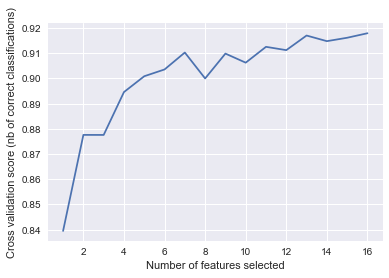

In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=rf_clf, step=1, cv= 10, scoring='accuracy')
rfecv.fit(train[features], train['bot'])

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [92]:
for x in sorted(zip(rfecv.grid_scores_,train[features])):
    print x

(0.83946130627744986, 'friends_count')
(0.8775685198330937, 'favourites_count')
(0.8775845712785173, 'followers_count')
(0.89459306159138008, 'verified')
(0.89999437297643559, 'acc_age')
(0.9008731805957142, 'listedcount')
(0.90356581958319615, 'ff_ratio')
(0.90626042442185928, 'name_bot_bool')
(0.90986402802546296, 'statuses_count')
(0.91028432340091547, 'tweets_per_day')
(0.9112314849282338, 'avg_In_reply')
(0.91255062517674612, 'desc_bot_bool')
(0.9148008935424855, 'avg_fav_count')
(0.91615224489383684, 'avg_total_usrmention')
(0.91703704024331822, 'avg_retweet_count')
(0.91794194498790915, 'days_std')


In [49]:
features = ['In_reply','acc_age','avg_In_reply','avg_fav_count','avg_retweet_count','avg_total_usrmention','days_std',
            'default_profile','fav_count','favourites_count','ff_ratio','followers_count','friends_count','has_extended_profile',\
            'hours_std','listedcount','nameratio','null_url','retweet_count','name_bot_bool','desc_bot_bool','n_count',\
            'sn_length','total_usrmention','tweets_per_day','verified']

In [88]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
train_ss = StandardScaler().fit(train[features])
train_poly = train_ss.transform(train[features])
test_poly = train_ss.transform(test[features])
test_final_poly = train_ss.transform(test_final[features])

In [77]:
from sklearn.neural_network import MLPClassifier
clf_mlp = MLPClassifier(solver='lbfgs', alpha=0.001,hidden_layer_sizes=(17,10), random_state=1,
                    activation='tanh',tol=0.000001,warm_start = 'false')

In [80]:
clf_mlp.fit(train_poly, train['bot'])
y_pred = clf_mlp.predict(test_poly)
print accuracy_score(test['bot'], y_pred)

print f1_score(test['bot'], y_pred)

a = cross_val_score(clf_mlp, train_poly, train['bot'], cv=10)
print a
print a.mean()

0.878136200717
0.868217054264
[ 0.88392857  0.88789238  0.91479821  0.90134529  0.85650224  0.86547085
  0.89686099  0.86547085  0.87443946  0.86036036]
0.880706920085


In [83]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(max_depth = 7, min_impurity_split = 0.00000001)
clf_tree = clf_tree.fit(train[features], train['bot'])
y_pred_tree = clf_tree.predict(test[features])

In [84]:
a = cross_val_score(clf_tree, train[features], train['bot'], cv=10)
print a
print a.mean()

[ 0.89732143  0.89686099  0.87443946  0.9058296   0.89686099  0.9103139
  0.86995516  0.9058296   0.87892377  0.8963964 ]
0.893273127788


In [85]:
print f1_score(test['bot'], y_pred_tree)

0.886639676113


In [ ]:
0.897849462366
[ 0.88839286  0.87892377  0.91928251  0.9058296   0.89237668  0.91479821
  0.88340807  0.86547085  0.91479821  0.8963964 ]